In [1]:
## final cnn

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
import os  # ✅ correct one, not osl
import glob
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

blank: 1616 files
ok: 1675 files
thumbsup: 1618 files
thumbsdown: 1641 files
fist: 1752 files
five: 2019 files
Total images loaded: 9600
Epoch 1/12, Loss: 1.9282
Validation Accuracy: 0.9031
Epoch 2/12, Loss: 0.4834
Validation Accuracy: 0.9396
Epoch 3/12, Loss: 0.4094
Validation Accuracy: 0.9589
Epoch 4/12, Loss: 0.3509
Validation Accuracy: 0.9766
Epoch 5/12, Loss: 0.2973
Validation Accuracy: 0.9786
Epoch 6/12, Loss: 0.2611
Validation Accuracy: 0.9797
Epoch 7/12, Loss: 0.2384
Validation Accuracy: 0.9917
Epoch 8/12, Loss: 0.2129
Validation Accuracy: 0.9943
Epoch 9/12, Loss: 0.2082
Validation Accuracy: 0.9927
Epoch 10/12, Loss: 0.2015
Validation Accuracy: 0.9953
Epoch 11/12, Loss: 0.1681
Validation Accuracy: 0.9964
Epoch 12/12, Loss: 0.1560
Validation Accuracy: 0.9969
Test Accuracy: 0.9969
Precision: 0.9969
Recall: 0.9969
F1-Score: 0.9969


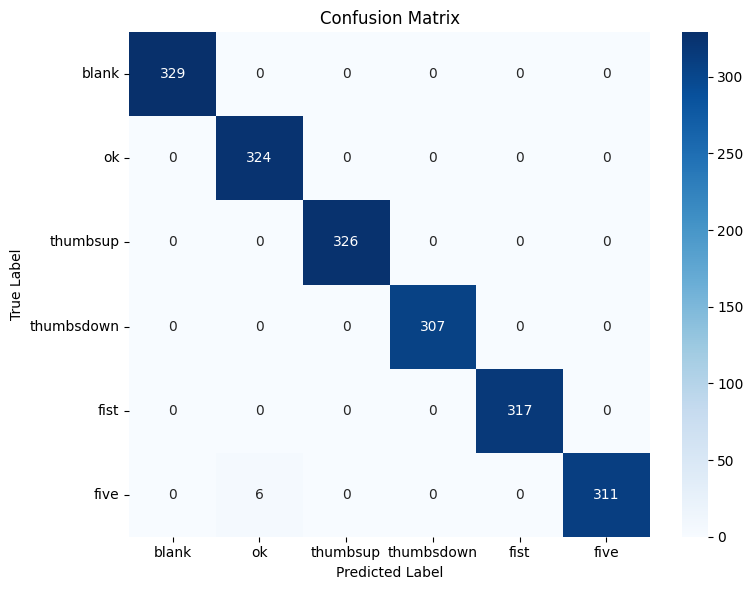

In [15]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# import cv2
# import os
# import glob
# from torch.utils.data import TensorDataset, DataLoader
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load and preprocess images
def load_images():
    loaded_images = []
    list_of_gestures = ['blank', 'ok', 'thumbsup', 'thumbsdown', 'fist', 'five']
    outputVectors = []
    
    # Use the correct data path
    data_path = "/home/npp-vlm/Dipan EXP/ADataMining/experiment_den_old/data"
    
    for path_idx, gesture in enumerate(list_of_gestures):
        gesture_path = os.path.join(data_path, gesture, '*')
        gest_path = glob.glob(gesture_path)
        print(f"{gesture}: {len(gest_path)} files")
        
        k = 0
        for i in range(len(gest_path)):
            if k < 1600:
                try:
                    image = cv2.imread(gest_path[i])
                    if image is None:
                        continue
                        
                    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    gray_image = cv2.resize(gray_image, [100, 120])
                    loaded_images.append(gray_image)
                    
                    # One-hot encoding
                    one_hot = [0] * 6
                    one_hot[path_idx] = 1
                    outputVectors.append(one_hot)
                    
                    k += 1
                except Exception as e:
                    print(f"Error with {gest_path[i]}: {e}")
    
    print(f"Total images loaded: {len(loaded_images)}")
    
    if len(loaded_images) == 0:
        raise ValueError("No images were loaded. Check your file paths.")
        
    # Convert to numpy arrays
    X = np.asarray(loaded_images)
    y = np.asarray(outputVectors)
    
    # Reshape and normalize
    X = X.reshape(X.shape[0], 1, 100, 120).astype('float32') / 255.0
    
    return X, y

# Define model
class HandGestureModel(nn.Module):
    def __init__(self):
        super(HandGestureModel, self).__init__()
        
        # First conv layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        
        # Second conv layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 25 * 30, 128)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 6)
    
    def forward(self, x):
        # First conv block
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Second conv block
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Flatten
        x = x.view(-1, 64 * 25 * 30)
        
        # Fully connected
        x = torch.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        
        return x

# Main function
def train_model():
    # Load data
    X, y = load_images()
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Convert to PyTorch tensors
    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train)
    X_test = torch.FloatTensor(X_test)
    y_test = torch.FloatTensor(y_test)
    
    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    # Initialize model
    model = HandGestureModel()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    # Training loop
    num_epochs = 12
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Convert one-hot to class indices
            _, labels = torch.max(labels, 1)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')
        
        # Validation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Convert one-hot to class indices
                _, labels = torch.max(labels, 1)
                
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            accuracy = correct / total
            print(f'Validation Accuracy: {accuracy:.4f}')
    
    # Save model
    torch.save(model.state_dict(), "hand_gesture_model.pth")
    
    # Final evaluation
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            
            # Convert one-hot to class indices for true labels
            _, true_labels = torch.max(labels, 1)
            all_labels.extend(true_labels.cpu().numpy())
            
            # Get predictions
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Define class names
    class_names = ['blank', 'ok', 'thumbsup', 'thumbsdown', 'fist', 'five']
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    train_model()